<img src='https://github.com/sentinel-hub/eo-learn/blob/master/docs/source/figures/eo-learn-logo.png' alt='eo-learn' width='300'/>

# CV4A ICRL Crop Type Classification Challenge
# Prepare data for training and evaluation using `eo-learn`

This notebook shows how to set up `eo-learn` workflows to pre-process data in `EOPatch` format. This allows to quickly evaluate different pre-processing methods.

Example workflows may include:

 * morphological operators on cloud probabilities/masks;
 * computation of vegetation indices (e.g. NDVI, TasselatedCAP)
 * interpolation/compositing for filling masked values;
 * sampling to retrieve only pixels used for training/testing.


Authors: Anže Zupanc, Devis Peressutti, EO Research Team, Sinergise eoresearch@sinergise.com

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import datetime
import tifffile as tiff
import glob

from tqdm.auto import tqdm

from eolearn.core import EOPatch, FeatureType, FeatureTypeSet, OverwritePermission, LinearWorkflow, LoadTask
from eolearn.core import MapFeatureTask, ZipFeatureTask, EOTask
from eolearn.features import SimpleFilterTask, LinearInterpolation, ValueFilloutTask, NormalizedDifferenceIndexTask

from skimage.morphology import disk, binary_dilation, binary_erosion

In [3]:
# location of directory to which data has been downloaded
ROOT_DATA_DIR = ''

In [4]:
bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'CLD']

In [5]:
dates = [datetime.datetime(2019, 6, 6, 0, 0),
 datetime.datetime(2019, 7, 1, 0, 0),
 datetime.datetime(2019, 7, 6, 0, 0),
 datetime.datetime(2019, 7, 11, 0, 0),
 datetime.datetime(2019, 7, 21, 0, 0),
 datetime.datetime(2019, 8, 5, 0, 0),
 datetime.datetime(2019, 8, 15, 0, 0),
 datetime.datetime(2019, 8, 25, 0, 0),
 datetime.datetime(2019, 9, 9, 0, 0),
 datetime.datetime(2019, 9, 19, 0, 0),
 datetime.datetime(2019, 9, 24, 0, 0),
 datetime.datetime(2019, 10, 4, 0, 0),
 datetime.datetime(2019, 11, 3, 0, 0)]

## Clouds

This utility functions allow to:

* convert cloud probailities to cloud masks
* post-process the mask given a morphological operator
   * remove small clouds (could be buildings falsely detected)
   * dilate masks to ensure bright pixels are not included

In [6]:
def to_mask(prob, threshold):
    """Converts a probability float array to binary mask array."""
    return prob>threshold

def cloud_coverage(mask):
    """Estimates cloud coverage (fraction of cloudy pixels) from a cloud mask"""
    return np.count_nonzero(mask.squeeze(),axis=(1,2))[...,np.newaxis]/mask[0,...,0].size

def post_process_mask(masks, operation, element):
    """Apply skimage operation over all masks (timeframes)."""
    pp_masks = np.asarray([operation(mask.squeeze(), element) for mask in masks], dtype=np.bool)
    return pp_masks[...,np.newaxis]

def count_fields(field_ids, crop_ids, train=True):
    """
    Counts number of (train/test) fields in an eopatch.
    
    Training fields have crop_id, while test fields don't.
    """
    crop_mask = (crop_ids.squeeze()==0)
    if train:
        crop_mask = (crop_ids.squeeze()!=0)
    
    field_count = np.count_nonzero(np.unique(field_ids.squeeze()[crop_mask]))

    return np.array([field_count])

class ValidDataFractionPredicate:
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, coverage):
        return coverage < self.threshold
    
class SampleValid(EOTask):
    """
    The task samples pixels with a value in given timeless feature different from no valid data value.
    """

    def __init__(self, feature, fraction=1.0, no_data_value=0, sample_features=...):
        """ Task to sample pixels from a reference timeless raster mask, excluding a no valid data value

        :param feature:  Reference feature used to select points to be sampled
        :param fraction: Fraction of valid points to be sampled
        :param no_data_value: Value of non-valid points to be ignored
        """
        self.feature_type, self.feature_name, self.new_feature_name = next(
            self._parse_features(feature, new_names=True,
                                 default_feature_type=FeatureType.MASK_TIMELESS,
                                 allowed_feature_types={FeatureType.MASK_TIMELESS},
                                 rename_function='{}_SAMPLED'.format)())
        self.fraction = fraction
        self.no_data_value = no_data_value
        self.sample_features = self._parse_features(sample_features)

    def execute(self, in_eopatch, seed=None):
        eopatch = in_eopatch.__copy__()

        mask = eopatch[self.feature_type][self.feature_name].squeeze()

        if mask.ndim != 2:
            raise ValueError('Invalid shape of sampling reference map.')

        np.random.seed(seed)

        rows, cols = np.where(mask != self.no_data_value)
        sampled = np.random.rand(len(rows)) > (1.0 - self.fraction)
        rows = rows[sampled]
        cols = cols[sampled]

        for feature_type, feature_name in self.sample_features(eopatch):

            if feature_type in FeatureTypeSet.RASTER_TYPES.intersection(FeatureTypeSet.SPATIAL_TYPES):

                if feature_type.is_time_dependent():
                    sampled_data = eopatch[feature_type][feature_name][:, rows, cols, :]
                else:
                    sampled_data = eopatch[feature_type][feature_name][rows, cols, :]

                # here a copy of sampled array is returned and assigned to feature of a shallow copy
                # orig_eopatch[feature_type][feature_name] remains unmodified
                eopatch[feature_type][feature_name] = sampled_data[..., np.newaxis, :]

        new_mask = np.ones_like(mask) * self.no_data_value
        new_mask[rows, cols] = mask[rows, cols]
        eopatch[self.feature_type][self.new_feature_name] = new_mask[..., np.newaxis]

        eopatch[FeatureType.SCALAR_TIMELESS]['SAMPLED_ROWS'] = rows
        eopatch[FeatureType.SCALAR_TIMELESS]['SAMPLED_COLS'] = cols

        return eopatch

Initialise `EOTask`s that will be used in pre-processing workflow. 

The [`MapFeatureMask`](https://eo-learn.readthedocs.io/en/latest/eolearn.core.core_tasks.html#eolearn.core.core_tasks.MapFeatureTask) applies a given function and hyper-parameters to the input features, generating the output features.

In [7]:
# convert cloud probas to cloud masks
cloud_mask = MapFeatureTask((FeatureType.DATA, 'CLOUD_PROB'), 
                            (FeatureType.MASK, 'CLOUD'),
                            to_mask,
                            threshold=50)

# apply erosion to cloud mask
cloud_erosion = MapFeatureTask((FeatureType.MASK, 'CLOUD'), 
                               (FeatureType.MASK, 'CLOUD'),
                               post_process_mask,
                               operation=binary_erosion,
                               element=disk(2))

# apply cloud dilation to cloud mask
cloud_dilation = MapFeatureTask((FeatureType.MASK, 'CLOUD'), 
                                (FeatureType.MASK, 'CLOUD'),
                                post_process_mask,
                                operation=binary_dilation,
                                element=disk(10))

# compute cloud coverage based 
add_cc = MapFeatureTask((FeatureType.MASK, 'CLOUD'),
                        (FeatureType.SCALAR, 'CLOUD_COVERAGE'),
                        cloud_coverage)

# filter out frames with valid data ratio higher than threshold
valid_data_predicate = ValidDataFractionPredicate(0.3)
filter_task = SimpleFilterTask((FeatureType.SCALAR, 'CLOUD_COVERAGE'), valid_data_predicate)

# count train fields
count_train_fields = ZipFeatureTask({FeatureType.MASK_TIMELESS: ['FIELD_ID', 'CROP_ID']},
                                    (FeatureType.SCALAR_TIMELESS, 'TRAIN_FIELDS_COUNT'),
                                    count_fields,
                                    train=True)

# count test fields
count_test_fields = ZipFeatureTask({FeatureType.MASK_TIMELESS: ['FIELD_ID', 'CROP_ID']},
                                   (FeatureType.SCALAR_TIMELESS, 'TEST_FIELDS_COUNT'),
                                   count_fields,
                                   train=False)

# define a valid data mask used in interpolation
valid_data = MapFeatureTask((FeatureType.MASK, 'CLOUD'), 
                            (FeatureType.MASK, 'VALID_DATA'),
                            np.logical_not) 

# ndvi
ndvi_task = NormalizedDifferenceIndexTask((FeatureType.DATA, 'S2-BANDS-L2A'),
                                          (FeatureType.DATA, 'NDVI'), 
                                          [7,3])

# interpolation
lin_interp = LinearInterpolation((FeatureType.DATA, 'S2-BANDS-L2A'), 
                                 mask_feature=(FeatureType.MASK, 'VALID_DATA'),
                                 copy_features=[(FeatureType.DATA, 'NDVI')], # comment this out if NDVI is not used
                                 resample_range=dates)

# sample only fields
sample = SampleValid((FeatureType.MASK_TIMELESS, 'FIELD_ID'), fraction=1.0, no_data_value=0)

# if invalid data are at beginning or end of time-series, pad with nearest value
fillout = ValueFilloutTask((FeatureType.DATA, 'S2-BANDS-L2A'))

In [8]:
class ComposeTask(EOTask):
    """Composes several tasks together.
    """

    def __init__(self, tasks):
        self.tasks = tasks

    def execute(self, eopatch):
        for t in self.tasks:
            eopatch = t(eopatch)
        return eopatch

In [9]:
workflow = ComposeTask([cloud_mask, 
                        #cloud_erosion, 
                        cloud_dilation, 
                        add_cc, 
                        #filter_task, 
                        count_train_fields, 
                        count_test_fields])

In [10]:
preprocess = ComposeTask([valid_data, ndvi_task, lin_interp, fillout]) 

# Inspect the data

In [11]:
eop_name = 'eopatch-00-3-1'
eop = workflow.execute(EOPatch.load(f'{ROOT_DATA_DIR}/eopatches/{eop_name}'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


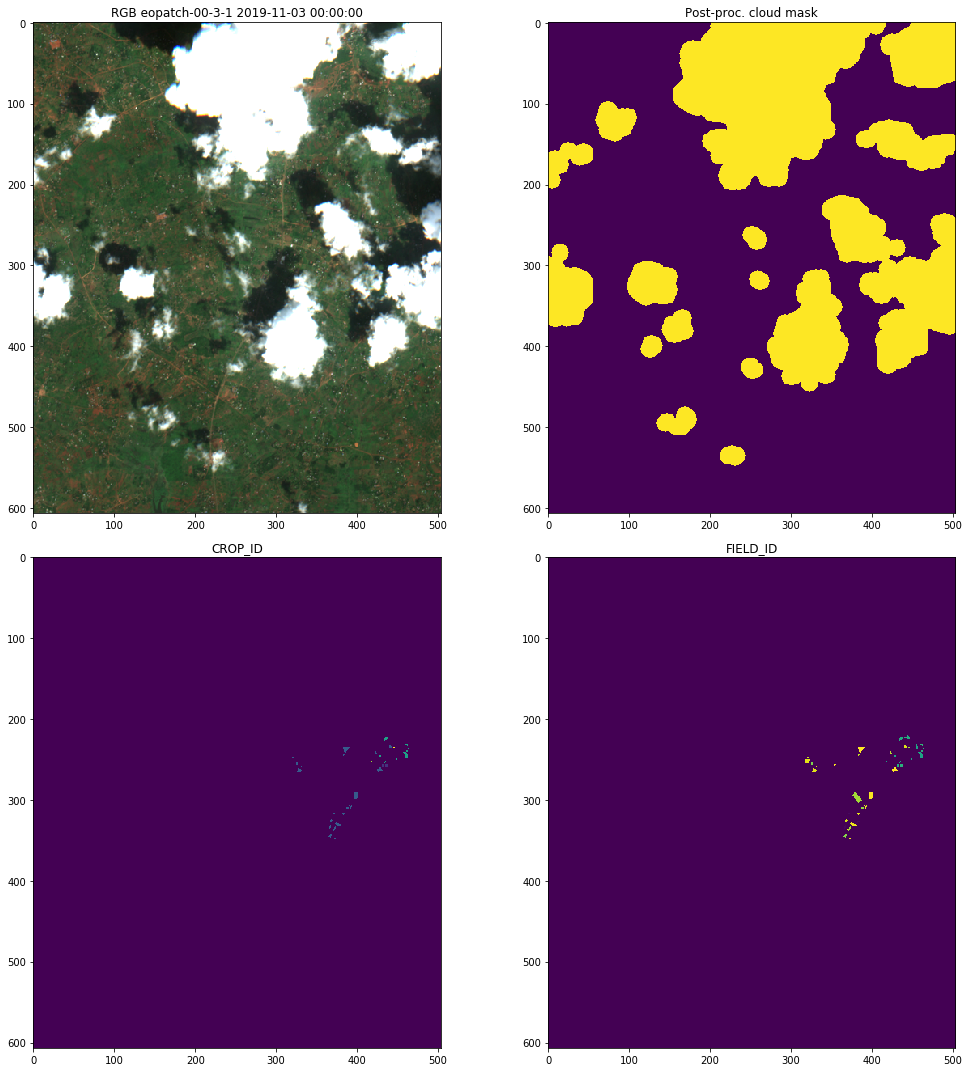

In [12]:
time_idx = -1

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

axs[0,0].imshow(np.moveaxis(eop.data['S2-BANDS-L2A'][time_idx,...,[3,2,1]],0,-1)*3.5)
axs[0,0].set_title(f'RGB {eop_name} {eop.timestamp[time_idx]}')
axs[0,1].imshow(eop.mask['CLOUD'][time_idx].squeeze())
axs[0,1].set_title(f'Post-proc. cloud mask')

axs[1,0].imshow(eop.mask_timeless['CROP_ID'].squeeze())
axs[1,0].set_title(f'CROP_ID')
axs[1,1].imshow(eop.mask_timeless['FIELD_ID'].squeeze())
axs[1,1].set_title(f'FIELD_ID')

plt.tight_layout()

### processed data

In [13]:
eop_linear = preprocess(eop)

In [14]:
eop_linear

EOPatch(
  data: {
    NDVI: numpy.ndarray(shape=(13, 607, 504, 1), dtype=float32)
    S2-BANDS-L2A: numpy.ndarray(shape=(13, 607, 504, 12), dtype=float64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: None
  timestamp: [datetime.datetime(2019, 6, 6, 0, 0), ..., datetime.datetime(2019, 11, 3, 0, 0)], length=13
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


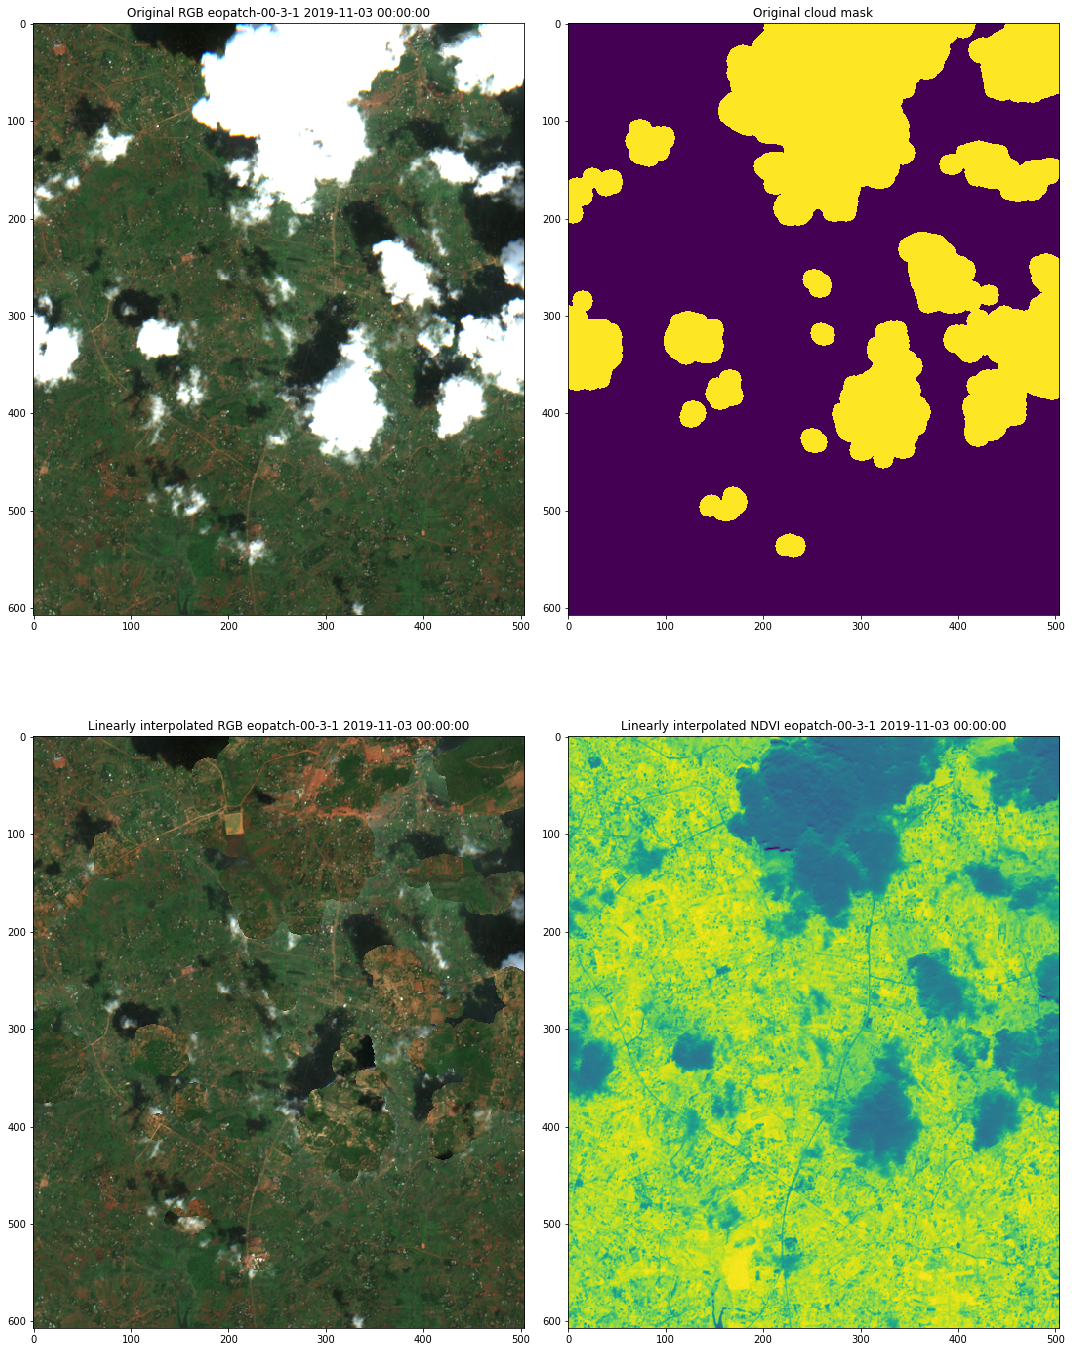

In [15]:
time_idx = -1

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 20))

axs[0,0].imshow(np.moveaxis(eop.data['S2-BANDS-L2A'][time_idx,...,[3,2,1]],0,-1)*3.5)
axs[0,0].set_title(f'Original RGB {eop_name} {eop.timestamp[time_idx]}')
axs[0,1].imshow(eop.mask['CLOUD'][time_idx].squeeze())
axs[0,1].set_title(f'Original cloud mask')
axs[1,0].imshow(np.moveaxis(eop_linear.data['S2-BANDS-L2A'][time_idx,...,[3,2,1]],0,-1)*3.5)
axs[1,0].set_title(f'Linearly interpolated RGB {eop_name} {eop.timestamp[time_idx]}')
axs[1,1].imshow(eop_linear.data['NDVI'][time_idx].squeeze())
axs[1,1].set_title(f'Linearly interpolated NDVI {eop_name} {eop.timestamp[time_idx]}')

plt.tight_layout()

# Process patches and sample all pixels with reference

Sampled eopatches are stored to new location

In [16]:
def get_all_field_count(eopatch):
    return np.count_nonzero(np.unique(eop.mask_timeless['FIELD_ID']))

def get_cloud_coverage(eopatch):
    return eopatch.scalar['CLOUD_COVERAGE'].squeeze()

def get_field_count(eopatch, train=True):
    feature = 'TEST_FIELDS_COUNT'
    if train:
        feature = 'TRAIN_FIELDS_COUNT'
    
    return eopatch.scalar_timeless[feature][0]

In [17]:
eopatch_names = glob.glob(f'{ROOT_DATA_DIR}/eopatches/*')

In [18]:
info = []

pbar = tqdm(total=len(eopatch_names))
for eopatch in eopatch_names:
    eop = EOPatch.load(eopatch, lazy_loading=True)
    eop = workflow(eop)
    
    name = eopatch.split('/')[-1]    
    for idx, date in enumerate(eop.timestamp):
        info.append({'eopatch':name, 'date':date, 
                     'field_count':get_all_field_count(eop),
                     'cloud_coverage':get_cloud_coverage(eop)[idx],
                     'n_train':get_field_count(eop),
                     'n_test':get_field_count(eop, train=False),
                    })
        
    # sample and save sample eopatch to disk
    sampled_eop = sample(eop)
    sampled_eop.save(eopatch.replace('eopatches','sampled-eopatches'),
                     overwrite_permission=OverwritePermission.OVERWRITE_PATCH)
    
    pbar.update()

### Merge all sampled pixels to numpy arrays

In [19]:
sampled_eopatch_names = glob.glob(f'{ROOT_DATA_DIR}/sampled-eopatches/*')

In [20]:
features = []
crop_id = []
field_id = []

pbar = tqdm(total=len(sampled_eopatch_names))
for eopatch in sampled_eopatch_names:
    eop = EOPatch.load(eopatch, lazy_loading=True)
    eop_proc =  preprocess(eop)
 
    ftr_arr = np.moveaxis(eop_proc.data['S2-BANDS-L2A'].squeeze(),1,0)
    ndvi_arr = np.moveaxis(eop_proc.data['NDVI'].squeeze(),1,0)
    cld_arr = np.moveaxis(eop.data['CLOUD_PROB'].squeeze(),1,0)
    
    features.append(np.concatenate((ftr_arr, ndvi_arr[...,np.newaxis], cld_arr[...,np.newaxis]), axis=-1))
    field_id.append(eop.mask_timeless['FIELD_ID'].squeeze())
    crop_id.append(eop.mask_timeless['CROP_ID'].squeeze())
    
    pbar.update()
    
features = np.concatenate(features)
field_id = np.concatenate(field_id)
crop_id = np.concatenate(crop_id)

In [21]:
features.shape, field_id.shape, crop_id.shape

((67557, 13, 14), (67557,), (67557,))

In [22]:
len(np.unique(field_id[crop_id==0])), len(np.unique(field_id[crop_id!=0]))

(1402, 3286)

### Vizualize Normalized Difference Vegetation index

In [23]:
ndvi = (features[...,7]-features[...,3])/(features[...,7]+features[...,3])

In [24]:
np.unique(crop_id, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8),
 array([19766, 25375,  9266,  1570,  6390,  2079,  2194,   917]))

In [25]:
def remove_arg(arg, kwargs):
    if arg in kwargs:
        kwargs_without_arg = kwargs.copy()
        del kwargs_without_arg[arg]
        return kwargs_without_arg

    return kwargs

def profile_plot(ax, date, values, std=None, **kwargs):
    """
    Adds profile plot to axes object.
    """
    kwargs_without_label = remove_arg('label', kwargs)
    kwargs_without_alpha = remove_arg('alpha', kwargs)

    ax.plot(date, values, **kwargs_without_alpha)
    if std is not None:
        ax.fill_between(date, values - std, values + std, **kwargs_without_label)

/home/users/dperessutti/dperessutti-venv-36/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


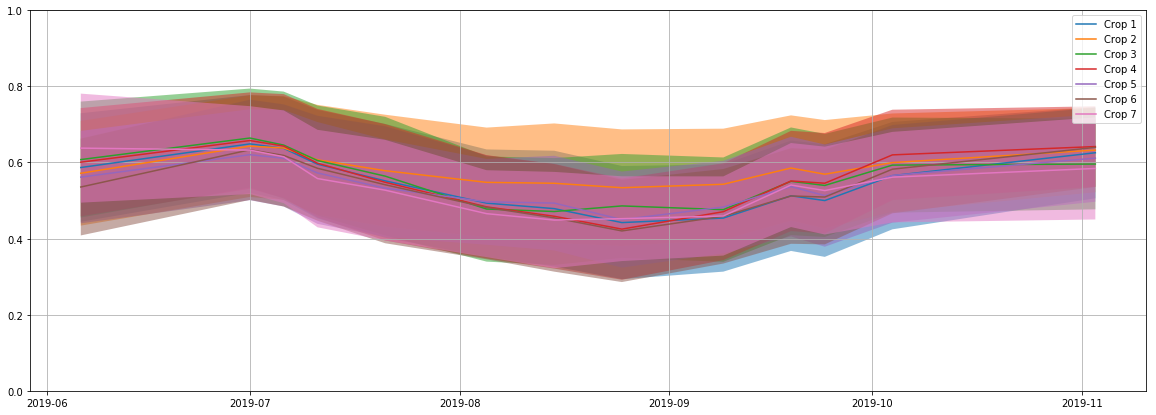

In [26]:
fig, axs = plt.subplots(figsize=(20,7))

crop_code = 1
profile_plot(axs, eop.timestamp, np.mean(ndvi[crop_id==crop_code],axis=0), np.std(ndvi[crop_id==crop_code],axis=0), 
             label=f'Crop {crop_code}', alpha=0.5)
crop_code = 2
profile_plot(axs, eop.timestamp, np.mean(ndvi[crop_id==crop_code],axis=0), np.std(ndvi[crop_id==crop_code],axis=0), 
             label=f'Crop {crop_code}', alpha=0.5)
crop_code = 3
profile_plot(axs, dates, np.mean(ndvi[crop_id==crop_code],axis=0), np.std(ndvi[crop_id==crop_code],axis=0), 
             label=f'Crop {crop_code}', alpha=0.5)
crop_code = 4
profile_plot(axs, dates, np.mean(ndvi[crop_id==crop_code],axis=0), np.std(ndvi[crop_id==crop_code],axis=0), 
             label=f'Crop {crop_code}', alpha=0.5)
crop_code = 5
profile_plot(axs, dates, np.mean(ndvi[crop_id==crop_code],axis=0), np.std(ndvi[crop_id==crop_code],axis=0), 
             label=f'Crop {crop_code}', alpha=0.5)
crop_code = 6
profile_plot(axs, dates, np.mean(ndvi[crop_id==crop_code],axis=0), np.std(ndvi[crop_id==crop_code],axis=0), 
             label=f'Crop {crop_code}', alpha=0.5)
crop_code = 7
profile_plot(axs, dates, np.mean(ndvi[crop_id==crop_code],axis=0), np.std(ndvi[crop_id==crop_code],axis=0), 
             label=f'Crop {crop_code}', alpha=0.5)
axs.grid()
axs.legend()
axs.set_ylim(0,1);

### Inspect other information

In [27]:
# df with all eopatches and all timeframes
df = pd.DataFrame(info)

# df with eopatches with reference info and aggregated over all timeframes
patchdf = df.groupby(by='eopatch').mean()
patchdf = patchdf.loc[(patchdf.n_train!=0) | (patchdf.n_test!=0)]
patchdf['ratio'] = patchdf.n_test/patchdf.n_train

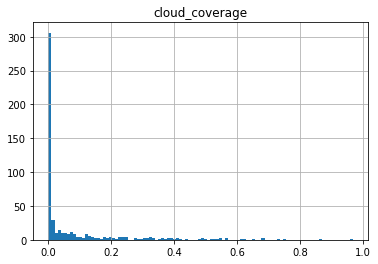

In [28]:
df.loc[df.field_count>0].hist('cloud_coverage',bins=100);

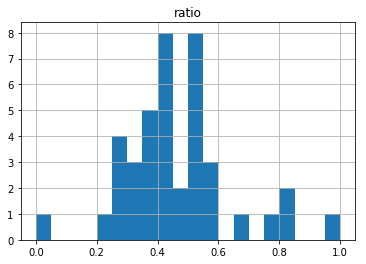

In [29]:
patchdf.hist('ratio',bins=20);

# Train a model

Split pixels into train/test set

In [30]:
X = features[crop_id>0]
y = crop_id[crop_id>0]
fid = field_id[crop_id>0]

X_test = features[crop_id==0]
y_test = crop_id[crop_id==0]
fid_test = field_id[crop_id==0]

In [31]:
fields, px_count = np.unique(fid, return_counts=True)

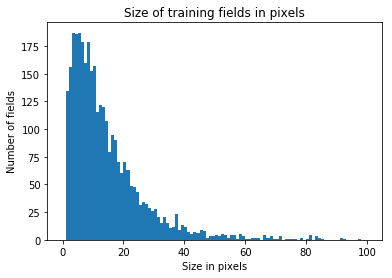

In [32]:
plt.hist(px_count, bins=100, range=(0,100));
plt.title('Size of training fields in pixels');
plt.xlabel('Size in pixels');
plt.ylabel('Number of fields');

Split training data into 90/10 

In [33]:
n_fields = len(np.unique(fid))
train_frac = 0.9

unq_field_ids = np.unique(fid)

random_state = 7
np.random.seed(random_state)
train_fields = np.random.choice(unq_field_ids, int(n_fields*train_frac), replace=False)
val_fields = unq_field_ids[~np.in1d(unq_field_ids, train_fields)]

In [34]:
len(train_fields), len(val_fields)

(2957, 329)

In [35]:
X_train = X[np.in1d(fid, train_fields)]
y_train = y[np.in1d(fid, train_fields)]

X_val = X[np.in1d(fid, val_fields)]
y_val = y[np.in1d(fid, val_fields)]

fid_train = fid[np.in1d(fid, train_fields)]
fid_val = fid[np.in1d(fid, val_fields)]

In [36]:
y_train.shape, y_val.shape, y.shape

((42893,), (4898,), (47791,))

#### Train RF model on pixels and get scores on cross-validation split

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.utils import shuffle

In [38]:
X_train, y_train, fid_train = shuffle(X_train, y_train, fid_train, random_state=random_state)

In [39]:
np.unique(y_train, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7], dtype=uint8),
 array([22551,  8434,  1460,  5823,  1781,  2010,   834]))

In [40]:
rf = RandomForestClassifier(n_estimators=500, random_state=random_state)

rf.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]), y_train)

preds = rf.predict_proba(X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2]))

#### Based on the starter code by JW

In [41]:
val_results = pd.DataFrame(preds,columns=['1','2','3','4','5','6','7'])

for c in range(1, 8):
    val_results['true'+str(c)] = (y_val == c).astype(int)
    
val_results['fid'] = field_id[np.in1d(field_id, val_fields)]

pred_cols = [str(i) for i in range(1, 8)]
true_cols = ['true'+str(i) for i in range(1, 8)]

# Score
print('Pixel score:', log_loss(val_results[true_cols], val_results[pred_cols])) # Note this isn't the score you'd get for a submission!!
print('Field score:', log_loss(val_results.groupby('fid').mean()[true_cols], 
                               val_results.groupby('fid').mean()[pred_cols])) # This is what we'll compare to

Pixel score: 1.1725526508856874
Field score: 1.2300359295702825


In [42]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [43]:
rf_preds =  rf.predict(X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2]))

accuracy_score(y_val, rf_preds)

0.6008574928542262

In [44]:
unq_lbls = np.unique(y_val)

f1_scores = metrics.f1_score(y_val, rf_preds, labels=unq_lbls, average=None)
recall = metrics.recall_score(y_val, rf_preds, labels=unq_lbls, average=None)
precision = metrics.precision_score(y_val, rf_preds, labels=unq_lbls, average=None)
    
for idx, class_id in enumerate(unq_lbls):
    print(f'        * class {class_id:5d} = {f1_scores[idx]*100:2.1f} | {recall[idx]*100:2.1f} | {precision[idx]*100:2.1f} | {np.count_nonzero(y_val==class_id):8d}')

        * class     1 = 74.4 | 89.9 | 63.4 |     2824
        * class     2 = 42.6 | 39.5 | 46.1 |      832
        * class     3 = 16.2 | 11.8 | 26.0 |      110
        * class     4 = 14.8 | 8.6 | 52.1 |      567
        * class     5 = 1.3 | 0.7 | 14.3 |      298
        * class     6 = 10.2 | 5.4 | 83.3 |      184
        * class     7 = 0.0 | 0.0 | 0.0 |       83


#### Based on the starter code by JW

In [45]:
tr = pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
tr['label'] = y_train 
tr['fid'] = fid_train
tr.head()

,0,1,2,3,4,5,6,7,8,9,...,174,175,176,177,178,179,180,181,label,fid
0,0.0614,0.0616,0.0883,0.0689,0.0990,0.1845,0.2259,0.2385,0.2434,0.2714,...,0.4079,0.4045,0.4258,0.3972,0.2280,0.1138,0.781546,0.0,1,2631
1,0.1782,0.1172,0.1352,0.1150,0.1710,0.3420,0.4078,0.4018,0.4239,0.4217,...,0.3078,0.2878,0.3314,0.3479,0.2287,0.1346,0.634299,0.0,1,1344
2,0.0325,0.0367,0.0768,0.0506,0.1194,0.3483,0.3967,0.4121,0.4392,0.3749,...,0.4079,0.4288,0.4385,0.4034,0.2742,0.1414,0.008679,100.0,1,2083
3,0.0778,0.1486,0.1482,0.1112,0.1554,0.2580,0.2891,0.3259,0.2973,0.3689,...,0.3218,0.3406,0.3419,0.3228,0.2241,0.1283,0.667564,0.0,4,1917
4,0.0299,0.0318,0.0580,0.0449,0.1222,0.2756,0.2973,0.2671,0.3401,0.3389,...,0.3746,0.3598,0.4138,0.4088,0.2017,0.1033,0.750000,0.0,1,616


In [46]:
val = pd.DataFrame(X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2]))
val['label'] = y_val 
val['fid'] = fid_val
val.head()

,0,1,2,3,4,5,6,7,8,9,...,174,175,176,177,178,179,180,181,label,fid
0,0.0360,0.0415,0.0809,0.0712,0.1221,0.2396,0.2608,0.3065,0.2918,0.3120,...,0.3202,0.3265,0.3363,0.3624,0.2502,0.1472,0.572736,0.0,2,4022
1,0.0386,0.0408,0.0729,0.0703,0.1222,0.2512,0.2872,0.2591,0.3167,0.3088,...,0.3782,0.3780,0.4026,0.3755,0.2231,0.1131,0.745555,0.0,2,4022
2,0.0386,0.0420,0.0760,0.0719,0.1222,0.2512,0.2872,0.2566,0.3167,0.3088,...,0.3782,0.3940,0.4026,0.3755,0.2231,0.1131,0.761681,0.0,2,4022
3,0.0328,0.0322,0.0568,0.0415,0.0897,0.2374,0.2843,0.2750,0.3212,0.3340,...,0.3395,0.3340,0.3753,0.3621,0.2277,0.1211,0.707566,0.0,5,4045
4,0.0328,0.0286,0.0570,0.0408,0.0897,0.2374,0.2843,0.2988,0.3212,0.3340,...,0.3395,0.3371,0.3753,0.3621,0.2277,0.1211,0.721655,0.0,5,4045


#### Training per-field using mean values

In [47]:
# Group
train_grouped = tr.groupby('fid').mean().reset_index()
val_grouped = val.groupby('fid').mean().reset_index()

X_train, y_train = train_grouped[train_grouped.columns[1:-2]], train_grouped['label']
X_val, y_val = val_grouped[val_grouped.columns[1:-2]], val_grouped['label']

In [48]:
np.unique(y_train, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7], dtype=uint8),
 array([1302,  757,   90,  440,  150,  146,   72]))

In [49]:
# Predicting on fields (grouping first)

# Fit model
model = RandomForestClassifier(n_estimators=500, random_state=random_state)
model.fit(X_train.fillna(-1), y_train)

# Get predicted probabilities
preds = model.predict_proba(X_val.fillna(-1))

# Add to val_grouped dataframe as columns
for i in range(7):
  val_grouped[str(i+1)] = preds[:,i]

# Get 'true' vals as columns in val
for c in range(1, 8):
  val_grouped['true'+str(c)] = (val_grouped['label'] == c).astype(int)

pred_cols = [str(i) for i in range(1, 8)]
true_cols = ['true'+str(i) for i in range(1, 8)]
val_grouped[['label']+true_cols+pred_cols].head()

# Already grouped, but just to double check:
print('Field score:', log_loss(val_grouped.groupby('fid').mean()[true_cols], 
                               val_grouped.groupby('fid').mean()[pred_cols]))

Field score: 1.2267174406723165


In [50]:
test = pd.DataFrame(X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
test['fid'] = fid_test
test.head()

,0,1,2,3,4,5,6,7,8,9,...,173,174,175,176,177,178,179,180,181,fid
0,0.1198,0.1328,0.1506,0.1260,0.1757,0.3038,0.3501,0.3550,0.3664,0.3631,...,0.3340,0.3955,0.3854,0.4153,0.3769,0.2609,0.1653,0.639302,0.0,1879
1,0.1198,0.1202,0.1566,0.1308,0.1823,0.3029,0.3494,0.3549,0.3655,0.3631,...,0.3153,0.3733,0.4164,0.4125,0.3769,0.2466,0.1314,0.732834,0.0,1879
2,0.1198,0.1274,0.1506,0.1274,0.1757,0.3038,0.3501,0.3543,0.3664,0.3631,...,0.3340,0.3955,0.4384,0.4153,0.3769,0.2609,0.1653,0.735894,0.0,1879
3,0.1198,0.1350,0.1486,0.1278,0.1757,0.3038,0.3501,0.3558,0.3664,0.3631,...,0.3340,0.3955,0.4047,0.4153,0.3769,0.2609,0.1653,0.645122,0.0,1879
4,0.1191,0.1334,0.1550,0.1360,0.1824,0.3012,0.3492,0.3581,0.3673,0.3684,...,0.3357,0.3896,0.3971,0.4211,0.3888,0.2940,0.1787,0.589354,0.0,1879


In [51]:
# Group test as we did for val
test_grouped = test.groupby('fid').mean().reset_index()
preds = model.predict_proba(test_grouped[test_grouped.columns[1:-1]])

prob_df = pd.DataFrame({
    'Field_ID':test_grouped['fid'].values
})
for c in range(1, 8):
    prob_df['Crop_ID_'+str(c)] = preds[:,c-1]
prob_df.head()

,Field_ID,Crop_ID_1,Crop_ID_2,Crop_ID_3,Crop_ID_4,Crop_ID_5,Crop_ID_6,Crop_ID_7
0,3,0.096,0.780,0.012,0.060,0.022,0.010,0.020
1,6,0.142,0.706,0.020,0.052,0.030,0.032,0.018
2,11,0.202,0.332,0.040,0.246,0.060,0.082,0.038
3,13,0.176,0.642,0.032,0.070,0.042,0.016,0.022
4,14,0.200,0.576,0.028,0.110,0.038,0.006,0.042


#### Save test results to .csv file for submission

In [52]:
sample_sub_path = f'{ROOT_DATA_DIR}/SampleSubmission.csv'
ss = pd.read_csv(sample_sub_path)
ss.head()

,Field_ID,Crop_ID_1,Crop_ID_2,Crop_ID_3,Crop_ID_4,Crop_ID_5,Crop_ID_6,Crop_ID_7
0,3,0,0,0,0,0,0,0
1,6,0,0,0,0,0,0,0
2,11,0,0,0,0,0,0,0
3,13,0,0,0,0,0,0,0
4,14,0,0,0,0,0,0,0


In [53]:
# Merge the two, to get all the required field IDs
ss = pd.merge(ss['Field_ID'], prob_df, how='left', on='Field_ID')
print(ss.isna().sum()['Crop_ID_1']) # Missing fields
# Fill in a low but non-zero val for the missing rows:
ss = ss.fillna(1/7) # There are 34 missing fields
ss.to_csv(f'{ROOT_DATA_DIR}/starter_nb_submission.csv', index=False)

0


Check if file was correctly written

In [54]:
pd.read_csv(f'{ROOT_DATA_DIR}/starter_nb_submission.csv').head()

,Field_ID,Crop_ID_1,Crop_ID_2,Crop_ID_3,Crop_ID_4,Crop_ID_5,Crop_ID_6,Crop_ID_7
0,3,0.096,0.780,0.012,0.060,0.022,0.010,0.020
1,6,0.142,0.706,0.020,0.052,0.030,0.032,0.018
2,11,0.202,0.332,0.040,0.246,0.060,0.082,0.038
3,13,0.176,0.642,0.032,0.070,0.042,0.016,0.022
4,14,0.200,0.576,0.028,0.110,0.038,0.006,0.042
